<a href="https://colab.research.google.com/github/pcarugno/Coursera_Capstone/blob/coursera_capstone/Coursera_Capstone_Project_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Coursera Capstone Project - Predict the severity of an accident in Seattle - Report

#### 1. Introduction

The aim of this project is to develop a machine learning tool that will help predicting the severity of an accident based on some key features (such as weather, driving conditions, road conditions etc). This problem is particularly important for the city of Seattle: the city has been moving towards achieving 0 traffic deaths and serious injuries by 2030 and has launched [Vision Zero](https://www.seattle.gov/visionzero) in 2015, but as explained in [this Seattle Transit Blog entry from 2018](https://seattletransitblog.com/2018/01/05/traffic-volumes-collision-rate/), collisions with fatal or serious injury jumped *16.5%* in 2016, even as traffic volumes remained nearly unchanged. It is hence of paramount importance to develop techniques that can help understand, predict and even avoid accidents based on their severity and that's what this project is about.


#### 2. Data

The data being used comprises every accident occurred in the city of Seattle between 2004 and 2020. The dimensions of the dataset are:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import folium

In [3]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
import warnings
warnings.filterwarnings("ignore")

In [4]:
coll_df = pd.read_csv(r'/content/drive/My Drive/Colab Notebooks/Coursera_Capstone/Data-Collisions.csv')
print('Dimensions of dataset:', coll_df.shape)

Dimensions of dataset: (194673, 38)


The dataset is hence comprised of 194673 records and 38 features. More information on the data and the adopted methodology are presented in the next section

#### 3. Methodology

In this section the exploratory data analysis, statistical testing and machine learning methodology adopted will be described.

#### 3.a Exploratory Data Analysis

To perform a meaningful exploratory data analysis we start by looking at the provided dataset global characteristics, such as number of features, whether these can be grouped in categories and what are the global statistics of the dataset.

In [5]:
coll_df.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE.1,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,5TH AVE NE AND NE 103RD ST,,NaN,2,Injury Collision,Angles,2,0,0,2,2013/03/27 00:00:00+00,3/27/2013 2:54:00 PM,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Overcast,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N,NaN,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,2006/12/20 00:00:00+00,12/20/2006 6:55:00 PM,Mid-Block (not related to intersection),16,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE ...",NaN,0,Raining,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST,NaN,NaN,1,Property Damage Only Collision,Parked Car,4,0,0,3,2004/11/18 00:00:00+00,11/18/2004 10:20:00 AM,Mid-Block (not related to intersection),14,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,0,Overcast,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,2ND AVE BETWEEN MARION ST AND MADISON ST,,NaN,1,Property Damage Only Collision,Other,3,0,0,3,2013/03/29 00:00:00+00,3/29/2013 9:26:00 AM,Mid-Block (not related to intersection),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,SWIFT AVE S AND SWIFT AV OFF RP,NaN,NaN,2,Injury Collision,Angles,2,0,0,2,2004/01/28 00:00:00+00,1/28/2004 8:04:00 AM,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,0,Raining,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [6]:
coll_df.columns

Index(['SEVERITYCODE', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'SEVERITYCODE.1', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE',
       'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')

We create a dictionary that contains the description of each feature in order to have a better idea of what each predictor/label means. To do so, we use the metadata associated with this dataset.

In [7]:
coll_dict = {
    "SEVERITYCODE": "A code that corresponds to the severity of the collision 3-fatality, 2b-serious injury, 2-injury, 1-prop damage, 0-unknown", 
    "X": "X location of accident (lat)", 
    "Y": "Y location of accident (long)",
    "OBJECTID": "ESRI unique identifier", 
    "INCKEY": "A unique key for the incident", 
    "COLDETKEY": "Secondary key for the incident",
    "REPORTNO": "Number of report (?)", 
    "STATUS": "Status of report (?)",
    "ADDRTYPE": "Collision address type: Alley, Block, Intersection", 
    "INTKEY": "Key that corresponds to the intersection associated with a collision", 
    "LOCATION": "Description of the general location of the collision",
    "EXCEPTRSNCODE": "", 
    "EXCEPTRSNDESC": "", 
    "SEVERITYCODE.1": "",
    "SEVERITYDESC": "A detailed description of the severity of the collision", 
    "COLLISIONTYPE": "Collision type", 
    "PERSONCOUNT": "The total number of people involved in the collision",
    "PEDCOUNT": "The number of pedestrians involved in the collision. This is entered by the state.", 
    "PEDCYLCOUNT": "The number of bicycles involved in the collision. This is entered by the state.", 
    "VEHCOUNT": "The number of vehicles involved in the collision. This is entered by the state.",
    "INCDATE": "The date of the incident", 
    "INCDTTM": "The date and time of the incident", 
    "JUNCTIONTYPE": "Category of junction at which collision took place",
    "SDOT_COLCODE": "A code given to the collision by SDOT", 
    "SDOT_COLDESC": "A description of the collision corresponding to the collision code", 
    "INATTENTIONIND": "Whether or not collision was due to inattention (Y/N)",
    "UNDERINFL": "Whether or not a driver involved was under the influence of drugs or alcohol", 
    "WEATHER": "A description of the weather conditions during the time of the collision", 
    "ROADCOND": "The condition of the road during the collision",
    "LIGHTCOND": "The light conditions during the collision", 
    "PEDROWNOTGRNT": "Whether or not the pedestrian right of way was not granted (Y/N)", 
    "SDOTCOLNUM": "A number given to the collision by SDOT",
    "SPEEDING": "Whether or not speeding was a factor in the collision (Y/N)", 
    "ST_COLCODE": "State-defined collision code", 
    "ST_COLDESC": "A description taht corresponds to the state's coding designation",
    "SEGLANEKEY": "A key for the lane segment in which the collision occurred",
    "CROSSWALKKEY" : "A key for the crosswalk at which the collision occurred",
    "HITPARKEDCAR" : "Whether or not the collision in volved hitting a parked car (Y/N)" 
}


From these preliminaries we can already see a potential grouping of features of the dataset:
- location -> X, Y, ADDRTYPE, LOCATION, JUNCTIONTYPE;
- date/time - season too -> INCDATE, INCDTTM;
- collision type -> SEVERITYDESC, COLLISIONTYPE, SDOT_COLCODE, SDOT_COLDESC
- collision causes and circumstances -> INATTENTIONIND, UNDERINFL, PEDROWNOTGRNT, SPEEDING, HITPARKEDCAR; 
- weather, road and light conditions -> WEATHER, ROADCOND, LIGHTCOND;
- number of pedestrian, vehicle, bicycles involved -> PERSONCOUNT, PEDCOUNT, PEDCYLCOUNT, VEHCOUNT.

So we start by looking at the first group of features: __location__. We do so by creating a location dataframe: loc_df.

In [8]:
loc_df = coll_df[['SEVERITYCODE','X','Y','ADDRTYPE','LOCATION','JUNCTIONTYPE']]
loc_df.head()

,SEVERITYCODE,X,Y,ADDRTYPE,LOCATION,JUNCTIONTYPE
0,2,-122.323148,47.703140,Intersection,5TH AVE NE AND NE 103RD ST,At Intersection (intersection related)
1,1,-122.347294,47.647172,Block,AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N,Mid-Block (not related to intersection)
2,1,-122.334540,47.607871,Block,4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST,Mid-Block (not related to intersection)
3,1,-122.334803,47.604803,Block,2ND AVE BETWEEN MARION ST AND MADISON ST,Mid-Block (not related to intersection)
4,2,-122.306426,47.545739,Intersection,SWIFT AVE S AND SWIFT AV OFF RP,At Intersection (intersection related)


We can have a look at the number of occurrences for each severity code based on ADDRTYPE and JUNCTIONTYPE to understand whether accidents occurred in some particular location rather than others.

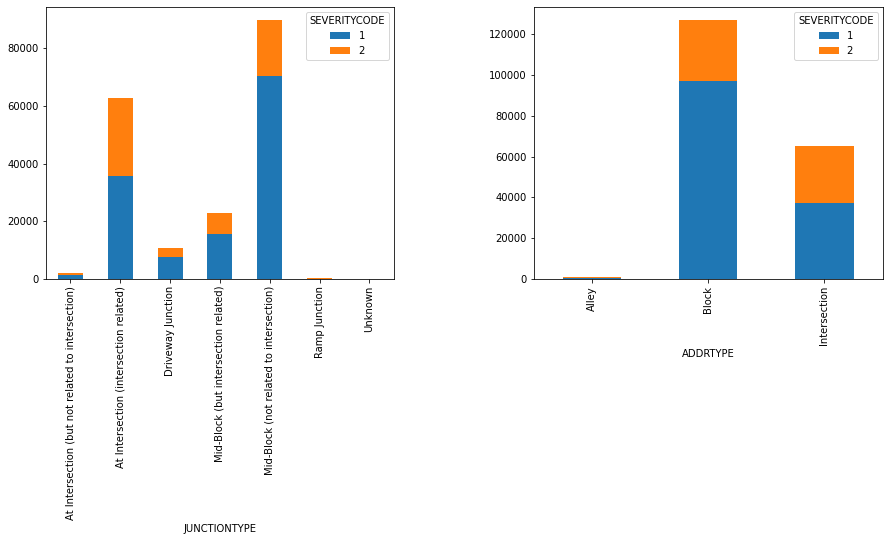

In [9]:
figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5));
# figure.tight_layout()
plt.subplots_adjust(wspace=0.4)

pd.crosstab(loc_df['JUNCTIONTYPE'],loc_df['SEVERITYCODE'] ).plot(kind='bar', stacked=True,ax=ax1);
pd.crosstab(loc_df['ADDRTYPE'],loc_df['SEVERITYCODE'] ).plot(kind='bar', stacked=True,ax=ax2);

From this first 2 plots we can observe that: 
- almost no accidents are occurring at ramp junction or at intersections (but not related to intersections)
- the majority of the accidents are either happening at intersection (intersection related) or at mid-block but not related to intersections
- of these two, the accidents happening at intersection (intersection related) are split half-half in terms of severity while for the mid-block related accidents the majority of the accidents are of severity 1
- when accidents are occurring at intersection, the severity is split between 1 and 2 almost equally in terms of occurrences while the type of accidents occurring at "block" are dominated by severity 1 accidents.

We can also have a look at the statistics of the loc_df database and observe where the mean location of accidents is within Seattle. Using the standard deviation along the x and y axes (i.e. longitude and latitude) we can draw a square around this mean location which could represent a rough estimation of the area where accidents occurred between 2004 and 2020.

In [10]:
X_std = loc_df.X.std()
X_mean = loc_df.X.mean()
Y_std = loc_df.Y.std()
Y_mean = loc_df.Y.mean()

In [11]:
# define the world map centered around Canada with a low zoom level
seattle = folium.Map(location=[Y_mean, X_mean], zoom_start=12)
folium.Marker([Y_mean, X_mean]).add_to(seattle)
# now I define the square of the box that should contain > 95% of collisions
points=[[Y_mean+Y_std,X_mean-X_std],[Y_std+Y_mean,X_mean+X_std],[Y_mean-Y_std,X_mean+X_std],[Y_mean-Y_std,X_mean-X_std],[Y_mean+Y_std,X_mean-X_std]]
folium.PolyLine(points,color="red", weight=2.5, opacity=1).add_to(seattle)
seattle

Now we move on to analysing the __date/time__ group of features, i.e. INCDATE, INCDTTM. We create a new dataframe called time_df.

In [12]:
time_df = coll_df[['SEVERITYCODE','INCDATE','INCDTTM']]
time_df.head()

,SEVERITYCODE,INCDATE,INCDTTM
0,2,2013/03/27 00:00:00+00,3/27/2013 2:54:00 PM
1,1,2006/12/20 00:00:00+00,12/20/2006 6:55:00 PM
2,1,2004/11/18 00:00:00+00,11/18/2004 10:20:00 AM
3,1,2013/03/29 00:00:00+00,3/29/2013 9:26:00 AM
4,2,2004/01/28 00:00:00+00,1/28/2004 8:04:00 AM


We notice already that INCDATE is superficial, so we can drop it, split the INCDTTM in year, month, day, hours, minutes, seconds

In [13]:
import datetime

In [14]:
time_df['INCDTTM'] =  pd.to_datetime(time_df['INCDTTM'], infer_datetime_format=True)
time_df['Time'] = [datetime.datetime.time(d) for d in time_df['INCDTTM']] 
time_df['Date'] = [datetime.datetime.date(d) for d in time_df['INCDTTM']]
time_df['Year'] = [datetime.datetime.date(d).year for d in time_df['INCDTTM']] 
time_df['Month'] = [datetime.datetime.date(d).month for d in time_df['INCDTTM']] 
time_df['Day'] = [datetime.datetime.date(d).day for d in time_df['INCDTTM']] 
time_df['Hours'] = [datetime.datetime.time(d).hour for d in time_df['INCDTTM']] 
time_df['Minutes'] = [datetime.datetime.time(d).minute for d in time_df['INCDTTM']] 
time_df['Seconds'] = [datetime.datetime.time(d).second for d in time_df['INCDTTM']]
time_df = time_df.drop(columns = ['INCDATE'])

In [15]:
time_df.head()

,SEVERITYCODE,INCDTTM,Time,Date,Year,Month,Day,Hours,Minutes,Seconds
0,2,2013-03-27 14:54:00,14:54:00,2013-03-27,2013,3,27,14,54,0
1,1,2006-12-20 18:55:00,18:55:00,2006-12-20,2006,12,20,18,55,0
2,1,2004-11-18 10:20:00,10:20:00,2004-11-18,2004,11,18,10,20,0
3,1,2013-03-29 09:26:00,09:26:00,2013-03-29,2013,3,29,9,26,0
4,2,2004-01-28 08:04:00,08:04:00,2004-01-28,2004,1,28,8,4,0


We perform a One Hot Encoding operation to convert the SEVERITYCODE feature into columns "Severity = 1" and "Severity = 2"

In [16]:
time_df['Severity = 1']= time_df['SEVERITYCODE'].apply(lambda x: 1 if (x<2)  else 0)
time_df['Severity = 2']= time_df['SEVERITYCODE'].apply(lambda x: 1 if (x>=2)  else 0)
time_df.head()
#Alternative method using pd.get_dummies:
#time_df = pd.merge(time_df, pd.get_dummies(time_df.SEVERITYCODE),left_index=True, right_index=True)

,SEVERITYCODE,INCDTTM,Time,Date,Year,Month,Day,Hours,Minutes,Seconds,Severity = 1,Severity = 2
0,2,2013-03-27 14:54:00,14:54:00,2013-03-27,2013,3,27,14,54,0,0,1
1,1,2006-12-20 18:55:00,18:55:00,2006-12-20,2006,12,20,18,55,0,1,0
2,1,2004-11-18 10:20:00,10:20:00,2004-11-18,2004,11,18,10,20,0,1,0
3,1,2013-03-29 09:26:00,09:26:00,2013-03-29,2013,3,29,9,26,0,1,0
4,2,2004-01-28 08:04:00,08:04:00,2004-01-28,2004,1,28,8,4,0,0,1


We now look at the average number of collisions per month averaged between 2004 and 2020 to see if there are any obvious spikes or odd behaviours - this is shown as percentage of Severity 1 and percentage of Severity 2 accidents.

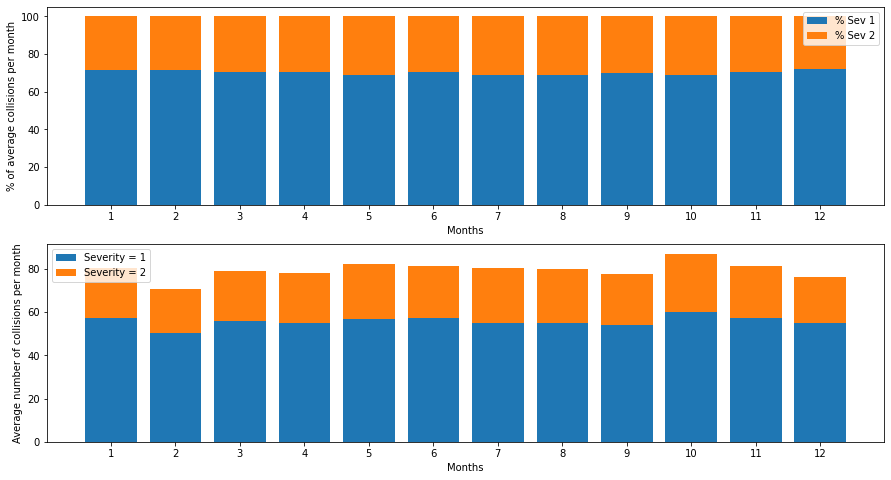

In [17]:
monthly_average = time_df.groupby(['Month'])['Severity = 1','Severity = 2'].sum()/(17*12)
monthly_average = monthly_average.reset_index()
monthly_average.head()

from matplotlib.pyplot import figure;

monthly_average['% Sev 1'] = 100*monthly_average['Severity = 1'] / (monthly_average['Severity = 1']+monthly_average['Severity = 2'])
monthly_average['% Sev 2'] = 100*monthly_average['Severity = 2'] / (monthly_average['Severity = 1']+monthly_average['Severity = 2'])

plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
plt.bar(monthly_average.Month, monthly_average['% Sev 1']);
plt.bar(monthly_average.Month, monthly_average['% Sev 2'], bottom =monthly_average['% Sev 1']);
plt.legend(['% Sev 1', '% Sev 2']);
plt.xticks(monthly_average.Month, monthly_average['Month'], rotation='horizontal');
plt.ylabel('% of average collisions per month');
plt.xlabel('Months');

plt.subplot(2,1,2)
plt.bar(monthly_average.Month, monthly_average['Severity = 1']);
plt.bar(monthly_average.Month, monthly_average['Severity = 2'], bottom =monthly_average['Severity = 1']);
plt.legend(['Severity = 1', 'Severity = 2']);
plt.xticks(monthly_average.Month, monthly_average['Month'], rotation='horizontal');
plt.ylabel('Average number of collisions per month');
plt.xlabel('Months');

#Alternative way (without doing reset_index above)
#monthly_average.plot.bar(stacked=True)

We can see from the plot above that there is no apparent trend and that Severity 1 accidents made up ~70% of total accidents per month between 2004 and 2020. Even looking at the average number of collisions per month doesn't seem to offer much more information. We now turn our attention to the annual trends.

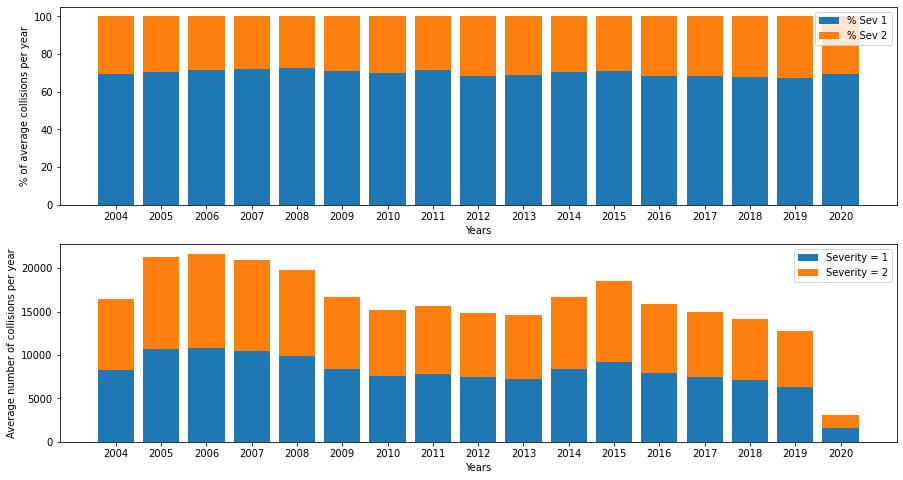

In [18]:
annual_trends_df = time_df.groupby(['Year'])['Severity = 1','Severity = 2'].sum();
annual_trends_df = annual_trends_df.reset_index()
plt.figure(figsize=(15,8))
annual_trends_df['% Sev 1'] = 100*annual_trends_df['Severity = 1'] / (annual_trends_df['Severity = 1']+annual_trends_df['Severity = 2'])
annual_trends_df['% Sev 2'] = 100*annual_trends_df['Severity = 2'] / (annual_trends_df['Severity = 1']+annual_trends_df['Severity = 2'])
plt.subplot(2,1,1)
plt.bar(annual_trends_df.Year, annual_trends_df['% Sev 1']);
plt.bar(annual_trends_df.Year, annual_trends_df['% Sev 2'], bottom =annual_trends_df['% Sev 1']);
plt.legend(['% Sev 1', '% Sev 2']);
plt.xticks(annual_trends_df.Year, annual_trends_df['Year'], rotation='horizontal');
plt.ylabel('% of average collisions per year');
plt.xlabel('Years');

plt.subplot(2,1,2)
plt.bar(annual_trends_df.Year, annual_trends_df['Severity = 1']);
plt.bar(annual_trends_df.Year, annual_trends_df['Severity = 1'], bottom =annual_trends_df['Severity = 1']);
plt.legend(['Severity = 1','Severity = 2']);
plt.xticks(annual_trends_df.Year, annual_trends_df['Year'], rotation='horizontal');
plt.ylabel('Average number of collisions per year');
plt.xlabel('Years');

From the first plot we can see that Severity 1 accidents made up ~70% of total accidents per year between 2004 and 2020. However, when looking at the average number of collisions per year we can see that between 2011/2012 to 2015 there was a constant increase in the total number accidents - we then observe a decrease from 2015 to 2019 - this coincides with the introduction of [Vision Zero](https://www.seattle.gov/visionzero) in 2015. The 2020 numbers are obviously only partial as the database stops at May 2020.

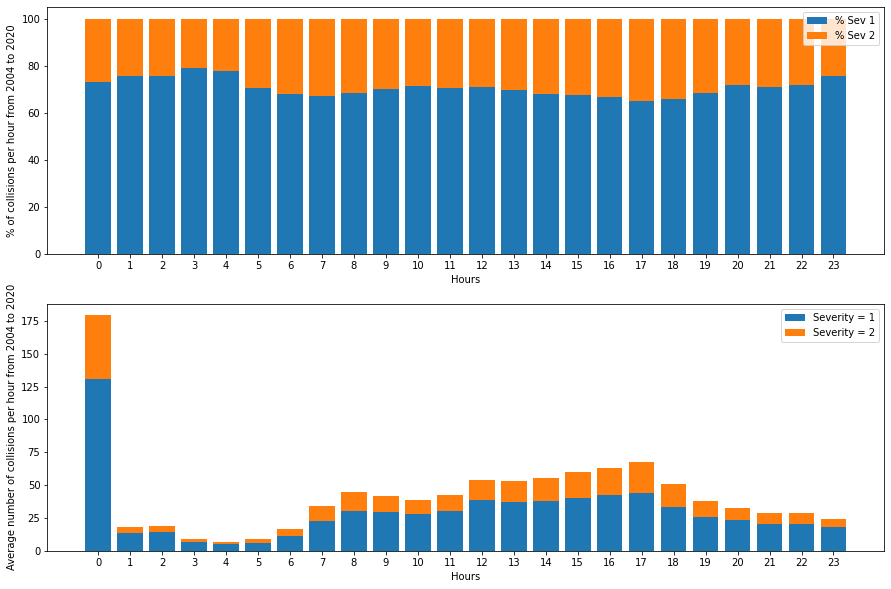

In [19]:
hourly_trends_df = time_df.groupby(['Hours'])['Severity = 1','Severity = 2'].sum()/(16*12);
hourly_trends_df = hourly_trends_df.reset_index()
plt.figure(figsize=(15,10))
hourly_trends_df['% Sev 1'] = 100*hourly_trends_df['Severity = 1'] / (hourly_trends_df['Severity = 1']+hourly_trends_df['Severity = 2'])
hourly_trends_df['% Sev 2'] = 100*hourly_trends_df['Severity = 2'] / (hourly_trends_df['Severity = 1']+hourly_trends_df['Severity = 2'])
plt.subplot(2,1,1)
plt.bar(hourly_trends_df.Hours, hourly_trends_df['% Sev 1']);
plt.bar(hourly_trends_df.Hours, hourly_trends_df['% Sev 2'], bottom =hourly_trends_df['% Sev 1']);
plt.legend(['% Sev 1', '% Sev 2']);
plt.xticks(hourly_trends_df.Hours, hourly_trends_df['Hours'], rotation='horizontal');
plt.ylabel('% of collisions per hour from 2004 to 2020');
plt.xlabel('Hours');

plt.subplot(2,1,2)
plt.bar(hourly_trends_df.Hours, hourly_trends_df['Severity = 1']);
plt.bar(hourly_trends_df.Hours, hourly_trends_df['Severity = 2'], bottom =hourly_trends_df['Severity = 1']);
plt.legend(['Severity = 1', 'Severity = 2']);
plt.xticks(hourly_trends_df.Hours, hourly_trends_df['Hours'], rotation='horizontal');
plt.ylabel('Average number of collisions per hour from 2004 to 2020');
plt.xlabel('Hours');

These last two plots are a bit more interesting and show the trend of number of collisions per hour, averaged on year and month. We can see 2 peaks: one at midnight and one at 5pm. In particular, the peak at midnight seems to be much higher than the other hourly values - let's dig more into the hours results to see if something odd is happening in the database. 
We start with searching for all the occurrences in the dataframe where the time of the collisions was 00:00:00 and all the occurrences in the dataframe where the collisions where recorded at other times than 00:00:00 (but still at 00 hours)

In [20]:
len(time_df.loc[(time_df.Hours == 0) & (time_df.Minutes==0) & (time_df.Seconds==0)])

30526

In [21]:
len(time_df.loc[(time_df.Hours == 0)])

34381

In [22]:
corrected_midnight = (len(time_df.loc[(time_df.Hours == 0)])-len(time_df.loc[(time_df.Hours == 0) & (time_df.Minutes==0) & (time_df.Seconds==0)]))/(16*12)
corrected_midnight

20.078125

From this first simple analysis we see that collisions recorded exactly at 00:00:00 time account for 30526 out of the 34381 that happened at 00 hours (basically between 12am and 1am). We can hypothize that those collisions recorded exactly at 00:00:00 were not updated with the correct time and when we look at the collisions that were recorded betwen 12am and 1am (but not exactly at 00:00:00), the average number of collisions per year, per month between 12am and 1am is much more in line with the rest of chart, that's to say ~20. With this information we can try to modify the plot above to a more realistic one - shown below - which now shows 2 relative peaks: one at 8am and one at 5pm, basically coinciding with peak hours with school runs and office commute, with the majority of Severity 2 accidents occuring towards the late afternoon/early evening.

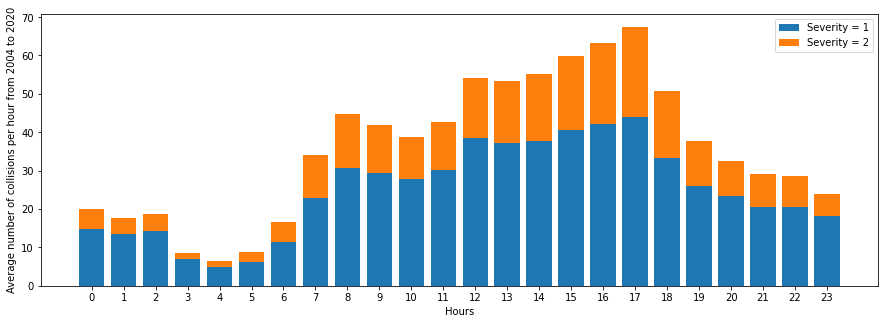

In [23]:
hourly_trends_corrected = hourly_trends_df
hourly_trends_corrected['Severity = 1'][0] = hourly_trends_df['% Sev 1'][0]*corrected_midnight/100
hourly_trends_corrected['Severity = 2'][0] = hourly_trends_df['% Sev 2'][0]*corrected_midnight/100

plt.figure(figsize=(15,5))
plt.bar(hourly_trends_corrected.Hours, hourly_trends_corrected['Severity = 1']);
plt.bar(hourly_trends_corrected.Hours, hourly_trends_corrected['Severity = 2'], bottom =hourly_trends_corrected['Severity = 1']);
plt.legend(['Severity = 1', 'Severity = 2']);
plt.xticks(hourly_trends_corrected.Hours, hourly_trends_corrected['Hours'], rotation='horizontal');
plt.ylabel('Average number of collisions per hour from 2004 to 2020');
plt.xlabel('Hours');

Now we consider the third group of features, i.e. __collision type__ made up of COLLISIONTYPE, SDOT_COLCODE, SDOT_COLDESC. We invoke the dictionary defined at the beginning of this report to remind ourselves what these features are.

In [24]:
print('COLLISIONTYPE:',coll_dict['COLLISIONTYPE'], '\nSDOT_COLCODE:', coll_dict['SDOT_COLCODE'], '\nSDOT_COLDESC:', coll_dict['SDOT_COLDESC'])

#coll_df.COLLISIONTYPE.unique()

COLLISIONTYPE: Collision type 
SDOT_COLCODE: A code given to the collision by SDOT 
SDOT_COLDESC: A description of the collision corresponding to the collision code


We assemble a new dataframe called coltype_df with the features above to examine them.

In [25]:
colltype_df = coll_df[['SEVERITYCODE','COLLISIONTYPE','SDOT_COLCODE','SDOT_COLDESC']]
colltype_df.head()

,SEVERITYCODE,COLLISIONTYPE,SDOT_COLCODE,SDOT_COLDESC
0,2,Angles,11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ..."
1,1,Sideswipe,16,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE ..."
2,1,Parked Car,14,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END"
3,1,Other,11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ..."
4,2,Angles,11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ..."


Looking at this dataframe we notice how some of the information is redundant and in fact can be retrieved by including also the group of features that is number of pedestrian, vehicle, bicycles involved and dropping the columns SDOT_COLCODE and SDOT_COLDESC.

In [26]:
colltype_df['PERSONCOUNT'] = coll_df['PERSONCOUNT']
colltype_df['PEDCOUNT'] = coll_df['PEDCOUNT']
colltype_df['PEDCYLCOUNT'] = coll_df['PEDCYLCOUNT']
colltype_df['VEHCOUNT'] = coll_df['VEHCOUNT']
colltype_df = colltype_df.drop(columns=['SDOT_COLCODE','SDOT_COLDESC'])
#one hot encoding to transform SEVERITYCODE column into 2 separate columns
colltype_df['Severity = 1']= colltype_df['SEVERITYCODE'].apply(lambda x: 1 if (x<2)  else 0)
colltype_df['Severity = 2']= colltype_df['SEVERITYCODE'].apply(lambda x: 1 if (x>=2)  else 0)
colltype_df.head()

,SEVERITYCODE,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,Severity = 1,Severity = 2
0,2,Angles,2,0,0,2,0,1
1,1,Sideswipe,2,0,0,2,1,0
2,1,Parked Car,4,0,0,3,1,0
3,1,Other,3,0,0,3,1,0
4,2,Angles,2,0,0,2,0,1


We can now run some statistics on this dataframe. For example we can have a look at how many accidents occured per collision type and how many vehicles, pedestrians and bicycles were involved.

In [27]:
colltype_df.groupby('COLLISIONTYPE')['Severity = 1','Severity = 2','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT'].sum()

,Severity = 1,Severity = 2,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT
COLLISIONTYPE,,,,,
Angles,21050,13624,60,17,71978
Cycles,671,4744,98,5447,5295
Head On,1152,872,0,1,4305
Left Turn,8292,5411,22,14,28117
Other,17591,6112,71,7,34276
Parked Car,45325,2662,72,6,102983
Pedestrian,672,5936,6857,4,6702
Rear Ended,19419,14671,27,7,75753
Right Turn,2347,609,5,3,5985
